[[  2.   1.]
 [  3.   1.]
 [  5.   3.]
 [  6.   1.]
 [  7.   1.]
 [  8.   6.]
 [  9.   8.]
 [ 10.   8.]
 [ 11.  19.]
 [ 12.  11.]
 [ 13.   9.]
 [ 14.   8.]
 [ 15.   8.]
 [ 16.  12.]
 [ 17.  20.]
 [ 18.  21.]
 [ 19.  19.]
 [ 20.  21.]
 [ 21.  15.]
 [ 22.  22.]
 [ 23.  17.]
 [ 24.  27.]
 [ 25.  21.]
 [ 26.  22.]
 [ 27.  23.]
 [ 28.  24.]
 [ 29.  37.]
 [ 30.  48.]
 [ 31.  40.]
 [ 32.  31.]
 [ 33.  43.]
 [ 34.  42.]
 [ 35.  33.]
 [ 36.  53.]
 [ 37.  34.]
 [ 38.  45.]
 [ 39.  42.]
 [ 40.  48.]
 [ 41.  39.]
 [ 42.  32.]
 [ 43.  40.]
 [ 44.  44.]
 [ 45.  40.]
 [ 46.  26.]
 [ 47.  30.]
 [ 48.  23.]
 [ 49.  25.]
 [ 50.  40.]
 [ 51.  36.]
 [ 52.  27.]
 [ 53.  24.]
 [ 54.  29.]
 [ 55.  20.]
 [ 56.  14.]
 [ 57.  19.]
 [ 58.  21.]
 [ 59.  20.]
 [ 60.  14.]
 [ 61.  12.]
 [ 62.  14.]
 [ 63.   9.]
 [ 64.  13.]
 [ 65.  15.]
 [ 66.  12.]
 [ 67.   2.]
 [ 68.  17.]
 [ 69.   8.]
 [ 70.   6.]
 [ 71.   9.]
 [ 72.   5.]
 [ 73.   9.]
 [ 74.  10.]
 [ 75.   6.]
 [ 76.   4.]
 [ 77.   3.]
 [ 78.   3.]
 [ 79.   4.]

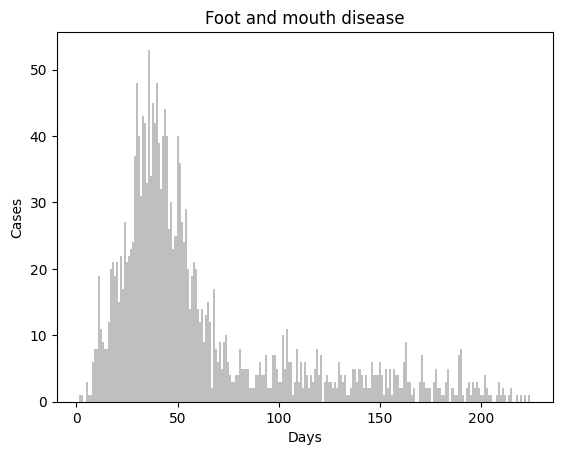

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Trace_analysis_final import*


fmd= np.loadtxt('processed_time_daily_cases.txt')
print(fmd)
plt.bar(fmd[:,0],fmd[:,1],width=1,color='gray', alpha=0.5)
plt.xlabel('Days')
plt.ylabel('Cases')
plt.title('Foot and mouth disease')

infec_times=[]

dic_day_cases={}
cutt_off_time = 82

for day in range(int(cutt_off_time)):
    dic_day_cases[day]=0

for data in fmd:
    if data[0]>cutt_off_time: break
    dic_day_cases[int(data[0])]=data[1]

infection_times=[]

for i in range(len(dic_day_cases.keys())):
    new_I=dic_day_cases[i]
    if new_I ==0: continue
    interval=1/new_I
    for j in range(int(new_I)):
        infection_times.append(i+j*interval)

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import seaborn as sns
from numpy import linalg as LA
from math import isnan
from PGF import * 
from RAM import *
import time
import random

'''##########################################################################################################################################################'''
'''############################################################  DATA PROCESSING ############################################################################'''
'''##########################################################################################################################################################'''

''' 
1- return_clen_data_perfect: Functions that cleans data for the case of having infection times and infection  periods. Or in this case, infection times, recovery times 
for each node

2- func_wieiti: Takes the output of 1 and returns just a list of infection times, recovery times and infection periods

3- return_clen_data_event: Functions that cleans data for the case of having infection times and infection  periods. Or in this case, infection times, recovery times 
for each node
'''


def return_clen_data_perfect_real(data,N=0):
    times=[]
    if N==0:
        N0=len(data)
    else: 
        N0=N
    K0=len(data)
    rho=1/N0
    I0=1
    return {'data': times, 'N0': N0, 'K0': K0, 'rho': rho, 'I0': I0}


def func_wieiti(data,Tmax=100):
    tr=[]; wi=[]; ei=[]; ti=[]
    list_=range(len(data))
    for i in list_:
        d=data[i]
        if d[0]!=0:
            ti.append(d[0])
        if d[1] != 'NR':
            tr.append(d[1])

    Tmax=max(max(ti),max(tr))
    for i in list_:
        d=data[i]
        if d[1]!='NR' and d[1]<Tmax:
            wi.append(d[1]-d[0])
        elif d[1]!='NR' and d[1]>Tmax:
            ei.append(Tmax-d[0])
            
    return ti,tr,wi,ei

def return_clean_data_event(data,proportion=1):
    N0=data[0,1]
    I0=data[0,2]
    rho = data[0,2]/N0

    data_S=[];data_R=[]

    for i in range(1, len(data)):
        if data[i-1, 1] - data[i, 1] == 1:
            data_S.append([data[i,0],data[i,1]])
        if data[i-1, 2] - data[i, 2] == 1:
            data_R.append([data[i,0],data[i,2]])

    if proportion!=1:
        data_S=random.sample(data_S,k=int(proportion*len(data_S)))
        data_R=random.sample(data_R,k=int(proportion*len(data_R)))

    data_S.sort()
    data_R.sort()
    data_all=[data_S,data_R]

    K0 = len(data_S) - I0  # final size of population
    
    return {'data': data_all, 'N0': N0, 'K0': K0, 'rho': rho, 'I0': I0}



'''##########################################################################################################################################################'''
'''######################################################  EBCM AND GENERATING FUNCTIONS ####################################################################'''
'''##########################################################################################################################################################'''
'''
The priors chosen for this case are gamma distribution non informative for beta, gamma, r and shift
and Beta distributions, non informative (uniform) for p and rho (which are restricted in the [0,1] range.

'''

def prior_value_Uniform(x, prior_param):
    """
    Computes the log-prior using uniform priors for all parameters.

    Parameters:
    - x: Parameter vector.
    - prior_param: List of (a, b) tuples for Uniform(a, a + b).

    Returns:
    - float: Total log-prior value.
    """
    prior = 0.0
    for i in range(len(x)):
        a, b = prior_param[i]
        prior += st.uniform(loc=a, scale=b).logpdf(x[i])
    return prior


def prior_value_Gamma(x, prior_param):
    """
    Computes the log-prior assuming:
    - Gamma priors for the first len(x)-1 parameters (e.g., beta, gamma, mu).
    - Beta(1,1) (i.e., Uniform) prior for the last parameter (rho).

    Parameters:
    - x: Vector of parameters.
    - prior_param: List of (a, b) tuples for Gamma(a, scale=b) priors.

    Returns:
    - float: Total log-prior value.
    """
    prior = 0.0
    for i in range(len(x) - 1):
        a, b = prior_param[i]
        prior += st.gamma(a=a, scale=b).logpdf(x[i])
    
    # Uniform prior for rho (Beta(1,1))
    prior += st.beta(a=1, b=1).logpdf(x[-1])
    return prior
    
def interp1d(obst, xmat):
    """
    Custom step-wise interpolation for matching observation times to ODE output.

    Parameters:
    - obst: List or array of observation times.
    - xmat: 2D array with time in first column and corresponding values in the others.

    Returns:
    - np.ndarray: Interpolated values at 'obst', keeping the original structure of xmat.
    """
    k = len(obst)
    jj = 0
    S_ti = np.zeros((k, xmat.shape[1]))
    S_ti[:, 0] = obst

    for i in range(k):
        for j in range(jj, xmat.shape[0]):
            if obst[i] <= xmat[j, 0]:
                S_ti[i, 1:] = xmat[j, 1:]
                jj = j
                break
    return S_ti


''' EBMC '''
def ode_EBCM(para, dS, psi, d1_psi, Tmax, steps_ode, theta0):
    """
    Solves the ODE system for the Edge-Based Compartmental Model (EBCM).

    Parameters:
    - para: Parameter vector [beta, gamma, ..., rho].
    - dS, psi, d1_psi: Model functions.
    - Tmax: Maximum time.
    - steps_ode: Number of steps in the solver.

    Returns:
    - thetas, S, I, R: Arrays representing the compartments over time.
    """
    dt = Tmax / steps_ode
    beta, gamma, rho = para[0], para[1], para[-1]
    ic = 1 - 1e-6  # initial theta

    thetas = np.zeros(steps_ode + 1)
    S = np.zeros(steps_ode + 1)
    I = np.zeros(steps_ode + 1)
    R = np.zeros(steps_ode + 1)

    thetas[0] = ic
    S[0] = 1
    I[0] = rho / (1 - rho)
    R[0] = 0

    for i in range(1, steps_ode + 1):
        x = thetas[i - 1]
        y = I[i - 1]

        dtheta = -beta * x + beta * (1 - rho) * d1_psi(x, para) / d1_psi(1, para) + gamma * (1 - x)
        dr = gamma * y

        thetas[i] = x + dtheta * dt
        R[i] = R[i - 1] + dr * dt
        S[i] = psi(thetas[i], para)
        I[i] = 1 / (1 - rho) - S[i] - R[i]

    return thetas, S, I, R


def dS_EBCM(theta, para, psi, d1_psi):
    """
    Computes dS/dt using EBCM formulation (chain rule on psi).

    Parameters:
    - theta: Array of theta values (susceptible edge fractions).
    - para: Model parameters.
    - psi: Generating function.
    - d1_psi: First derivative of psi.

    Returns:
    - np.ndarray: Time derivative of S.
    """
    beta, gamma, rho = para[0], para[1], para[-1]
    res = d1_psi(theta, para) * (
        -beta * theta + beta * (1 - rho) * d1_psi(theta, para) / d1_psi(1, para) + gamma * (1 - theta)
    )

    # Normalization or stability adjustment
    if np.max(res) > 0:
        res = res - np.max(res) - 1e-100
    return res




'''##########################################################################################################################################################'''
'''######################################################  LIKELIHOODS AND AUXILIARY FUNC ###################################################################'''
'''##########################################################################################################################################################'''

def f_r(para, t, log=False):
    """
    Computes the probability density of recovery time, f_R(t),
    assumed to follow an exponential distribution with rate gamma.

    Parameters:
    - para: List or array-like of model parameters. gamma is expected at index 1.
    - t: Time (or array of times) at which to evaluate the density.
    - log: If True, return log-density.

    Returns:
    - float or np.ndarray: Density (or log-density) evaluated at time t.
    """
    gamma = para[1]

    if log:
        # Log of exponential PDF: log(f(t)) = log(gamma) - gamma * t
        return np.log(gamma) - gamma * t
    else:
        return gamma * np.exp(-gamma * t)

def I_tiu(I, times, para, tau):
    """
    Computes the normalized recovery time distribution (f_R) over time.

    Parameters:
    - I: Array of infectious individuals over time (from ODE).
    - times: Time vector corresponding to I.
    - para: Model parameters. gamma = para[1], rho = para[-1].
    - tau: Final attack rate (1 - min(S)), used to scale densities.

    Returns:
    - np.ndarray: Normalized recovery time density f_R(t) over 'times'.
    """
    gamma = para[1]
    rho = para[-1]
    dt = times[-1] / len(times)  # Time step for numerical integration

    # Compute raw (unnormalized) density values
    fr_raw = gamma * (I - rho * np.exp(-gamma * times)) / tau

    # Trapezoidal rule to integrate (normalize) the density
    integral = np.trapz(fr_raw, times)
    fr_normalized = fr_raw / integral

    return fr_normalized

def Log_Likelihood_L1_L2(data_clear,wieiti,para,functions,T,steps_ode,theta0):
    """
    Computes the log-likelihood using:
    - Infection times (t_i)
    - Infection durations (w_i and e_i)

    Parameters:
    - data_clear: Preprocessed data dictionary.
    - wieiti: Tuple of (w_i, e_i, t_i) infection-related times.
    - para: Parameter vector [beta, gamma, ..., rho].
    - functions: Tuple of model functions (psi, d1_psi, dS, prior_value).
    - T: Time horizon.
    - steps_ode: Resolution of the ODE solver.

    Returns:
    - float: Computed log-likelihood.
    """
    psi,d1_psi,dS,prior_value=functions
    beta=para[0]; gam=para[1]; rho=para[-1]
    data_all=data_clear['data']
    wi,ei,ti = wieiti

    # Solve EBCM ODE
    thetas,S,I,R = ode_EBCM(para,dS,psi,d1_psi,Tmax=T,steps_ode=steps_ode,theta0=theta0)
    tau = 1 - S[-1]
    times=np.linspace(0,T,steps_ode+1)

    # Infection time density (ft)
    ft_res = np.column_stack((times, -dS(thetas,para,psi,d1_psi)/tau))
    ft = interp1d(ti, ft_res)

    # Components of likelihood
    L3 = np.nansum(np.log(ft[:,1]))  # Infection time density
    L4 = np.nansum([f_r(para, t, log=True) for t in wi])  # Distribution over infection durations
    L5 = -gam * sum(ei)

    return L3 + L4 + L5

def Log_Likelihood_L1_L3(data_clear,t_it_r,para,functions,T,steps_ode,theta0):
    '''Computes the log-likelihood using:
    - Infection times (t_r)
    - Recovery times (t_r)

    Returns:
    - float: Computed log-likelihood.
    '''
    #proportion=0.1
    data_all=data_clear['data']
    psi,d1_psi,dS,prior_value=functions
    beta=para[0]; gam=para[1]; rho=para[-1]
    t_i,t_r=t_it_r

    # Solve EBCM ODE
    thetas,S,I,R = ode_EBCM(para,dS,psi,d1_psi,Tmax=T,steps_ode=steps_ode,theta0=theta0)
    tau = 1 - S[-1]
    times=np.linspace(0,T,steps_ode+1)

    # Infection and recovery densities
    ft_ode=np.column_stack((times, -dS(thetas,para,psi,d1_psi)/tau))
    fr_ode=np.column_stack((times,I_tiu(I,times,para,tau)))
    ft = interp1d(t_i, ft_ode)
    fr= interp1d(t_r, fr_ode)

    # Components of likelihood
    L3=np.nansum(np.log(ft[:,1]))
    L4=np.nansum(np.log(fr[:,1]))

    return L3 + L4


def Log_Likelihood_L1(data_clear,t_it_r,para,functions,T,steps_ode,theta0):
    '''    Computes the log-likelihood using only:
    - Infection times (t_r)

    Returns:
    - float: Computed log-likelihood.
    '''
    data_all=data_clear['data']
    psi,d1_psi,dS,prior_value=functions
    beta=para[0]; gam=para[1]; rho=para[-1]
    t_i=t_it_r

    # Solve EBCM ODE
    thetas,S,I,R = ode_EBCM(para,dS,psi,d1_psi,Tmax=T,steps_ode=steps_ode,theta0=theta0)
    tau = 1 - min(S)
    times=np.linspace(0,T,steps_ode+1)

    # Infection density
    ft_ode=np.column_stack((times, -dS(thetas,para,psi,d1_psi)/tau))
    ft = interp1d(t_i, ft_ode)

    # Components of likelihood
    L3 = np.nansum(np.log(ft[:,1]))

    return L3 


def Log_Likelihood_L3(data_clear,t_it_r,para,functions,T,steps_ode,theta0):
    '''  Computes the log-likelihood using only:
    - Recovery times (t_r)

    Returns:
    - float: Computed log-likelihood.
    '''
    data_all=data_clear['data']
    psi,d1_psi,dS,prior_value=functions
    beta=para[0]; gam=para[1]; rho=para[-1]
    t_i,t_r=t_it_r

    # Solve EBCM ODE
    thetas,S,I,R = ode_EBCM(para,dS,psi,d1_psi,Tmax=T,steps_ode=steps_ode, theta0=theta0)
    tau = 1 - min(S)
    times=np.linspace(0,T,steps_ode+1)

    # Recovery density
    ft_ode=np.column_stack((times, -dS(thetas,para,psi,d1_psi)/tau))
    fr_ode=np.column_stack((times,I_tiu(I,times,para,tau)))
    fr= interp1d(t_r, fr_ode)

    # Components of likelihood
    L4 = np.nansum(np.log(fr[:,1]))
        
    return L4



def Log_Likelihood_L3(data_clear, t_it_r, para, functions, T, steps_ode, theta0):
    """

    """
    psi, d1_psi, dS, _ = functions
    _, t_r = t_it_r
    N, K, M = data_clear['N0'], data_clear['K0'], data_clear['I0']

    thetas, S, I, R = ode_EBCM(para, dS, psi, d1_psi, Tmax=T, steps_ode=steps_ode, theta0=theta0)
    tau = 1 - min(S)
    times = np.linspace(0, T, steps_ode + 1)

    # Recovery density
    ft_ode=np.column_stack((times, -dS(thetas,para,psi,d1_psi)/tau))
    fr_ode=np.column_stack((times,I_tiu(I,times,para,tau)))
    fr= interp1d(t_r, fr_ode)

    
    L1 = (N - K) * np.log(1 - tau)
    L2 = K * np.log(tau)
    

    return L1 + L2 + L4

def accept_proposal(proposal, current, prior_param, data, celar_times,Log_Likelihood, functions, T, A, steps_ode,theta0):
    """
    Computes the Metropolis-Hastings acceptance ratio for a proposed parameter update.

    Parameters:
    - proposal (array): Proposed parameter vector.
    - current (array): Current parameter vector.
    - prior_param (list): Parameters for the prior distribution.
    - data (any): Processed input data (e.g., from data_clear).
    - clear_times (tuple): Extracted event times used in the likelihood.
    - Log_Likelihood (function): Likelihood function.
    - functions (tuple): Tuple of model-related functions; last entry should be the prior.
    - T (float): Time horizon.
    - A (float or None): Previously computed log-posterior of the current state.
    - steps_ode (int): Resolution of the ODE solver.

    Returns:
    - acceptance_ratio (float): Ratio of proposed to current posterior (unnormalized).
    - A (float): Log-posterior of the current state (cached or recomputed).
    - B (float): Log-posterior of the proposed state.
    """
    # Extract prior function
    prior_value = functions[-1]

    # === Compute log-posterior of current state (A), if not already done ===
    if A is None:
        prior_current = prior_value(current, prior_param)
        Jac_curr=sum(np.log(current)) + np.log(1-current[-1])
        likelihood_current = Log_Likelihood(data, celar_times,current,functions,T,steps_ode,theta0)
        A=likelihood_current + Jac_curr+prior_current 

    # === Compute log-posterior of proposed state (B) ===
    prior_proposal = prior_value(proposal, prior_param)
    Jac_prop=sum(np.log(proposal)) + np.log(1-proposal[-1])
    likelihood_proposal = Log_Likelihood(data,celar_times,proposal,functions,T,steps_ode,theta0)

    
    # === Calculate acceptance ratio (unnormalized) ===
    B= likelihood_proposal + Jac_prop +prior_proposal 
    
    return np.exp(B-A),A,B


'''##########################################################################################################################################################'''
'''#################################################################  MAIN FUNCTION #########################################################################'''
'''##########################################################################################################################################################'''

def RAM_EBCM(data, initial_para, prior_param, functions, T, known_para, 
             sample_size=2000, progress=True, steps_ode=4000, Data_type='NB',theta0=1e-6,N=10000):
 
    """
    Performs Bayesian inference using the RAM-EBCM method.

    Parameters:
    - data (array-like): Raw epidemic data input.
    - functions (tuple): Tuple of functions (psi, d1_psi, etc.).
    - initial_para (list): Initial parameter values for inference.
    - prior_param (list): Parameters of the prior distribution for each parameter to be inferred.
    - T (float): Cutt-off time (Last observation)
    - known_para (list): List of tuples (index, value) for known parameters.
    - sample_size (int): Number of MCMC samples to generate.
    - progress (bool): Whether to print progress updates.
    - steps_ode (int): Number of steps in the ODE solver.
    - Data_type (str): Specifies type of likelihood to use.

    Returns:
    - trace (list): List of accepted parameter vectors.
    - acceptance_history (list): Rolling acceptance rate.
    """
    
    
    # === Preprocessing and Data Setup ===
    data_clear=return_clen_data_perfect_real(data,N=N)
    print(len(infection_times))
    # === Likelihood Selection ===

    if Data_type=='L1+L2':
        Log_Likelihood, clear_times, message = Log_Likelihood_L1_L2, (sorted(data[0]), sorted(data[1]), sorted(data[2])), 'L1 + L2'
    elif Data_type=='L1+L3':
        Log_Likelihood, clear_times, message = Log_Likelihood_L1_L3, (sorted(data[0]), sorted(data[1])), 'L1 + L3'
    elif Data_type=='L1':
        Log_Likelihood, clear_times, message = Log_Likelihood_L1, (sorted(data[0])), 'L1 only'
    elif Data_type=='L3':
        Log_Likelihood, clear_times, message = Log_Likelihood_L3, (sorted(data[0])), 'L3 only'
    else:
        raise ValueError("Invalid Data_type. Must be one of 'L1+L2', 'L1+L3', 'L1', or 'L3'.")

    print(f"Using likelihood: {message}")
    
    # === Initialization ===
    current = np.array(initial_para)
    dim = len(current)
    theta0 = 1e-6
    psi, d1_psi = functions[:2]

    S = np.identity(dim)  # Initial covariance matrix for proposals
    A = None              # Initial auxiliary variable
    trace = [current]
    acceptance_history = []
    acceptances = 0
    iterations = 0
    progress_step = sample_size // 10

    Max_iterations=1e3
    # === MCMC Sampling Loop ===
    
    while iterations < sample_size:
        if progress and iterations % progress_step == 0:
            print(f"{(iterations / sample_size) * 100:.0f}% completed")

        iterations += 1

        # --- Propose a new sample ---
        counter=0
        while True:
            u_prop = np.random.multivariate_normal(mean=np.zeros(dim), cov=np.diag(np.ones(dim) * 0.01))
            S_proposal = np.concatenate((np.log(current[:-1]), qlogis(current[-1:]))) + S @ u_prop
            proposal = np.concatenate((np.exp(S_proposal[:-1]), plogis(S_proposal[-1:])))

            # Check model constraint (custom logic)
            prop_test = (
                -proposal[0] * (1 - theta0) +
                proposal[0] * (1 - proposal[-1]) * d1_psi(1 - theta0, proposal) / d1_psi(1, proposal) +
                proposal[1] * theta0
            )
            counter+=1
            if counter>Max_iterations: raise ValueError(f"Poposal attempt exceeded maximum iterion.")
            if prop_test < 0:
                break

        # --- Apply known parameters ---
        if known_para:
            for index, value in known_para:
                proposal[index] = value

        # Avoid numerical underflow
        proposal = np.maximum(proposal, 1e-200)

        # --- Evaluate proposal ---
        alpha_n, A, B = accept_proposal(proposal, current, prior_param, data_clear, clear_times, Log_Likelihood, functions, T, A, steps_ode,theta0)
        alpha_n = min(1, alpha_n)

        # --- Accept or Reject ---
        if np.random.rand() < alpha_n and not np.isnan(alpha_n):
            current = proposal
            A = B
            acceptances += 1

        trace.append(current)
        acceptance_history.append(acceptances / iterations)

        # --- Adapt proposal covariance matrix ---
        S = adapt_S(S, u_prop, alpha_n, i=iterations, gam=min(1, -2/3))

    return trace, acceptance_history


def Inference_RAM(infection_times, initial_para, prior_param, T, prior='Gamma', sample_size=2000, 
                  progress=True, steps_ode=4000, Degree_distrib='NB', 
                  data_sets=1, Data_type='L1', known_para=None):
    """
    Run RAM-EBCM inference across multiple datasets.

    Parameters:
    - loc (str): File path prefix (e.g., './data/data').
    - initial_para (list): Initial parameter values for inference.
    - prior_param (list): Parameters of the prior distribution for each parameter to be inferred.
    - T (float): Cutt-off time (Last observation)
    - prior (str): Type of prior distribution ('Gamma' or 'Uniform').
    - sample_size (int): expected MCMC sample size.
    - progress (bool): Whether to show progress prints.
    - steps_ode (int): Steps used in ODE solver.
    - Degree_distrib (str): Network degree distribution ('Poi', 'Reg', 'NB').
    - data_sets (int): Number of datasets to process (e.g., for simulations).
    - Data_type (str): Data structure type.
    - known_para (list): List of known parameter (index, value) pairs.

    Returns:
    - posteriors (list): Posterior samples from each dataset.
    """

    # === Select prior function ===
    dS = dS_EBCM
    if prior == 'Uniform':
        prior_value = prior_value_Uniform
    elif prior == 'Gamma':
        prior_value = prior_value_Gamma
    else:
        raise ValueError("Unsupported prior type. Use 'Gamma' or 'Uniform'.")

    # === Select degree distribution functions ===
    degree_functions = {
        'Poi': (psi_Poi, d1_psi_Poi, 4),
        'Reg': (psi_Reg, d1_psi_Reg, 4),
        'NB': (psi_NB, d1_psi_NB, 5)}

    if Degree_distrib not in degree_functions:
        raise ValueError("Invalid Degree_distrib. Use 'Poi', 'Reg', or 'NB'.")

    psi, d1_psi, expected_param_size = degree_functions[Degree_distrib]

    if len(initial_para) != expected_param_size:
        raise ValueError(f"Expected {expected_param_size} parameters for {Degree_distrib} distribution.")

    functions = (psi, d1_psi, dS, prior_value)
    posteriors = []

    # === Loop over datasets ===
    for i in range(data_sets):
        print(f"Realisation {i+1}  using {Degree_distrib}...")

        # Run inference
        trace, acceptance_history = RAM_EBCM(data,initial_para,prior_param,functions,T,known_para,
                                             sample_size=sample_size,steps_ode=steps_ode,progress=progress, 
                                            Data_type=Data_type,theta0=theta0,N=N)
        

        # Transpose trace for output
        traces = [[x[j] for x in trace] for j in range(len(trace[0]))]
        posteriors.append(traces)

    return posteriors

    

In [92]:
start =  time.time()
from math import isnan
N=3000
beta = 0.05; gamma = 0.2; mu=10; rr = 3; rho = 0.001
p=rr/(rr+mu)
T=100

para_real = [beta,gamma,mu,rr,rho]

theta0=1e-6#-get_theta0(p,rr,rho)
dim = len(para_real)
#Prior Parameters
prior_param = []  # List of priors: each is [alpha, beta] for a Gamma distribution
prior_param.append([0.005,5])
prior_param.append([0.005,10])
prior_param.append([0,100])
prior_param.append([0,100])
prior_param.append([0,0.1])

#kp=[[2,21]]

chain_lenght=5000
resol=500
num_sets=1
''' #################################################### SIMULATION ###############################################################'''
data=[infection_times]
#NB DATA
print(type(infection_times))
# Run inference algorithm (RAM MCMC with specified options)
Postirior = Inference_RAM(
    data, para_real,              # File location and true parameters
    prior_param, T,              # Prior hyperparameters and observation window
    sample_size=chain_lenght,    # Number of MCMC samples
    progress=True,               # Show progress bar (if implemented)
    steps_ode=resol,             # Resolution used in internal solver
    prior='Uniform',               # Prior distribution family
    Degree_distrib='NB',         # Assumed offspring distribution (e.g. Negative Binomial)
    data_sets=num_sets,          # Number of synthetic datasets to use
    Data_type='L1'            # Level/type of data (e.g. full infection and recovery info)
)


Postiriors_file_array=np.array(Postirior)
Postiriors_file_reshaped = Postiriors_file_array.reshape(Postiriors_file_array.shape[0], -1)
Post_save=pd.DataFrame(Postiriors_file_reshaped)




end =  time.time()
print('Time', end - start)

<class 'list'>
Realisation 1  using NB...
1585
Using likelihood: L1 only
0% completed


C:\Users\jg3509phd\AppData\Local\Temp\ipykernel_31720\967444280.py:471: RuntimeWarning: overflow encountered in exp
  return np.exp(B-A),A,B


10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
Time 192.78854703903198


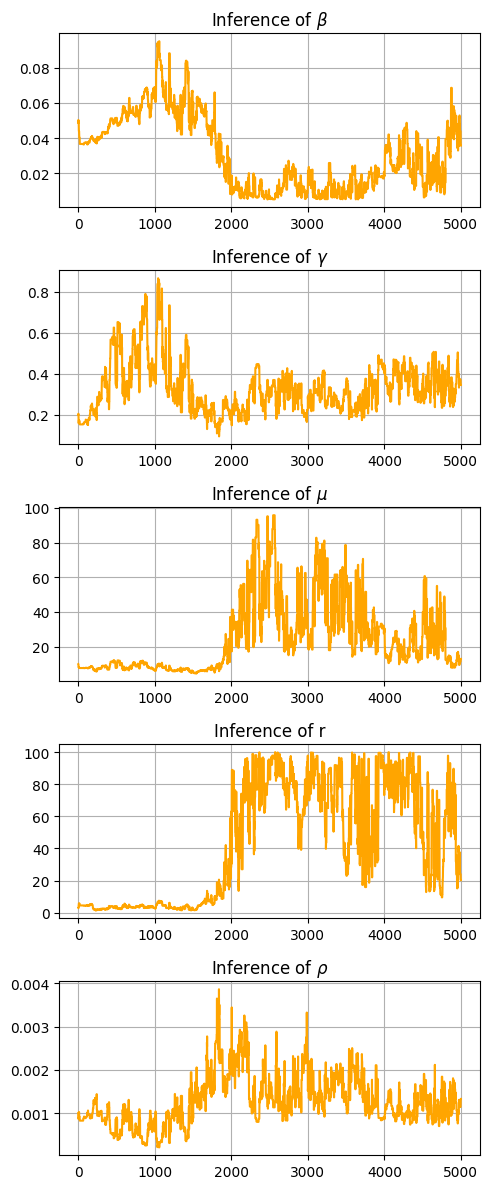

In [87]:
variables_NBk =[r'$\beta$', r'$\gamma$', r'$\mu$', r'r',r'$\rho$']
#var_NBp =[r'$\beta$', r'$\gamma$', 'r', r'shift','p', r'$\rho$']
Plot_chains(Postirior[0],parameter_names=variables_NBk)

In [13]:
start =  time.time()
from math import isnan
N=3000
beta = 0.05; gamma = 0.2; mu=10; rr = 3; rho = 0.001
p=rr/(rr+mu)
T=100

para_real = [beta,gamma,mu,rr,rho]

theta0=1e-8#-get_theta0(p,rr,rho)
print('theta_0', theta0)
dim = len(para_real)
#Prior Parameters
prior_param = []  # List of priors: each is [alpha, beta] for a Gamma distribution
prior_param.append([0.005,5])
prior_param.append([0.005,10])
prior_param.append([0,100])
prior_param.append([0,100])
prior_param.append([0,0.1])

chain_lenght=5000
resol=500
num_sets=1
''' #################################################### SIMULATION ###############################################################'''

#NB DATA

#Perfect data
loc=''
Postirior=Inference_RAM(loc, para_real, prior_param, T, sample_size=chain_lenght,progress=True,steps_ode=resol, Degree_distrib='NBk', 
                           data_sets=num_sets, Data_type='L1',theta0=theta0,N=N)

Postiriors_file_array=np.array(Postirior)
Postiriors_file_reshaped = Postiriors_file_array.reshape(Postiriors_file_array.shape[0], -1)
Post_save=pd.DataFrame(Postiriors_file_reshaped)




end =  time.time()
print('Time', end - start)

theta_0 1e-08


TypeError: Inference_RAM() got an unexpected keyword argument 'theta0'